<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Cell-meta" data-toc-modified-id="Cell-meta-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Cell meta</a></span></li><li><span><a href="#MCDS" data-toc-modified-id="MCDS-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>MCDS</a></span></li></ul></li><li><span><a href="#Filter-feature" data-toc-modified-id="Filter-feature-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Filter feature</a></span><ul class="toc-item"><li><span><a href="#Remove-chromosome" data-toc-modified-id="Remove-chromosome-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Remove chromosome</a></span></li><li><span><a href="#Remove-blacklist-region" data-toc-modified-id="Remove-blacklist-region-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Remove blacklist region</a></span></li><li><span><a href="#Remove-by-mean-cov" data-toc-modified-id="Remove-by-mean-cov-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Remove by mean cov</a></span></li></ul></li><li><span><a href="#Add-mC-rate" data-toc-modified-id="Add-mC-rate-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Add mC rate</a></span></li><li><span><a href="#Select-HVF" data-toc-modified-id="Select-HVF-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Select HVF</a></span><ul class="toc-item"><li><span><a href="#mCH-HVF" data-toc-modified-id="mCH-HVF-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>mCH HVF</a></span></li><li><span><a href="#mCG-HVF" data-toc-modified-id="mCG-HVF-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>mCG HVF</a></span></li></ul></li><li><span><a href="#Get-Anndata" data-toc-modified-id="Get-Anndata-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Get Anndata</a></span><ul class="toc-item"><li><span><a href="#Load-HVF" data-toc-modified-id="Load-HVF-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Load HVF</a></span></li><li><span><a href="#CH-adata" data-toc-modified-id="CH-adata-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>CH adata</a></span></li><li><span><a href="#CG-adata" data-toc-modified-id="CG-adata-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>CG adata</a></span></li></ul></li><li><span><a href="#Prepare-Gene" data-toc-modified-id="Prepare-Gene-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Prepare Gene</a></span></li></ul></div>

# Prepare AnnData and Highly Variable Feature Selection

## Purpose
- Calculate methylation rate
- Normalize per cell and clip extreme
- HVF selection
- Prepare HVF adata file
- Prepare gene adata file
- Basically, from N-D to 2-D

## Input
- Cell metadata table, MCDS list

## Output
- mCH HVF adata
- mCG HVF adata
- Gene rate MCDS

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import seaborn as sns
import xarray as xr
from ALLCools.mcds.MCDS import MCDS
from cemba_data.plot import *

In [3]:
result_dir = pathlib.Path('Adata')
result_dir.mkdir(exist_ok=True)
fig_dir = pathlib.Path('fig/feature_selection')
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
in_memory = True
dask_distribute = False

# selected cell metadata path
cell_meta_path = ''

# mcds_path
mcds_path_list = []

clustering_feature = 'chrom100k'  # usually 100kb chromosome bins or genes

# remove bad features
black_list_region = None
exclude_chromosome = ['chrY', 'chrM']

# preprocess parameters
min_feature_cov, max_feature_cov = 500, 3000

ch_hvf_top = 3000
min_ch_hvf_mean = 0.5
max_ch_hvf_mean = 2.5

cg_hvf_top = 3000
min_cg_hvf_mean = 0.5
max_cg_hvf_mean = 1.2

In [5]:
# Parameters
in_memory = True
dask_distribute = False
cell_meta_path = "/home/hanliu/project/mouse_rostral_brain/study/MOp/MGE-Pvalb/CellMetadata.AfterQC.msg"
mcds_path_list = ["/home/hanliu/project/mouse_rostral_brain/dataset/2C-180409.mcds", "/home/hanliu/project/mouse_rostral_brain/dataset/2C-180410.mcds", "/home/hanliu/project/mouse_rostral_brain/dataset/3C-171206.mcds", "/home/hanliu/project/mouse_rostral_brain/dataset/3C-171207.mcds", "/home/hanliu/project/mouse_rostral_brain/dataset/4B-171212.mcds", "/home/hanliu/project/mouse_rostral_brain/dataset/4B-171213.mcds", "/home/hanliu/project/mouse_rostral_brain/dataset/4B-180104.mcds", "/home/hanliu/project/mouse_rostral_brain/dataset/5D-180605.mcds", "/home/hanliu/project/mouse_rostral_brain/dataset/5D-180612.mcds"]
clustering_feature = "chrom100k"
black_list_region = None
exclude_chromosome = ["chrY", "chrM"]
min_feature_cov = 500
max_feature_cov = 3000
ch_hvf_top = 3000
min_ch_hvf_mean = 0.5
max_ch_hvf_mean = 2.5
cg_hvf_top = 3000
min_cg_hvf_mean = 0.5
max_cg_hvf_mean = 1.2


In [6]:
if dask_distribute:
    from dask.distributed import Client
    client = Client(dashboard_address=':5555')

## Load data
### Cell meta

In [7]:
cell_meta = pd.read_msgpack('CellMetadata.AfterQC.msg')

### MCDS

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mcds = MCDS.open(mcds_path_list,
                     use_cells=cell_meta[cell_meta['PassFilter']].index,
                     chunks={'cell': 1000})
if in_memory:
    mcds.load()

In [9]:
mcds

<xarray.MCDS>
Dimensions:              (cell: 460, chrom100k: 27269, count_type: 2, gene: 55487, mc_type: 2)
Coordinates:
  * mc_type              (mc_type) object 'CGN' 'CHN'
  * gene                 (gene) object 'ENSMUSG00000102693.1' ... 'ENSMUSG00000064372.1'
  * count_type           (count_type) object 'mc' 'cov'
    strand_type          <U4 'both'
    gene_chrom           (gene) object 'chr1' 'chr1' 'chr1' ... 'chrM' 'chrM'
    gene_start           (gene) int64 3073252 3102015 3205900 ... 15288 15355
    gene_end             (gene) int64 3074321 3102124 3671497 ... 15354 15421
  * cell                 (cell) object '2C_M_107' '2C_M_1083' ... '5D_M_978'
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 27265 27266 27267 27268
    chrom100k_chrom      (chrom100k) object 'chr1' 'chr1' ... 'chrY' 'chrM'
    chrom100k_bin_start  (chrom100k) int64 0 100000 200000 ... 91700000 0
    chrom100k_bin_end    (chrom100k) int64 100000 200000 ... 91744698 16299
Data variables:
    gene_

## Filter feature

### Remove chromosome

In [10]:
mcds = mcds.sel(chrom100k=~mcds.coords[f'{clustering_feature}_chrom'].isin(
    exclude_chromosome))

### Remove blacklist region

In [11]:
# TODO

### Remove by mean cov

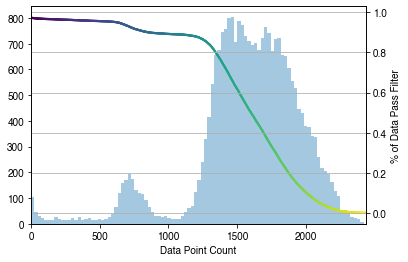

In [12]:
# only calculate CHN

fig, axes = cutoff_vs_cell_remain(mcds[f'{clustering_feature}_da']\
                                  .sel(count_type='cov', mc_type='CHN')\
                                  .mean(axis=0)\
                                  .load())
fig.savefig(fig_dir / f'region_mean_CHN_cov.pdf')

In [13]:
before = mcds.coords[clustering_feature].size
mcds = mcds.filter_region_cov(dim=clustering_feature,
                              da=f'{clustering_feature}_da',
                              mc_type='CHN',
                              min_cov=min_feature_cov,
                              max_cov=max_feature_cov)
after = mcds.coords[clustering_feature].size
print(
    f'Filter {clustering_feature} by [{min_feature_cov}, {max_feature_cov}], '
    f'filter rate {(after / before):.2f}. {after} features remained.')

Filter chrom100k by [500, 3000], filter rate 0.96. 25198 features remained.


In [14]:
mcds

<xarray.MCDS>
Dimensions:              (cell: 460, chrom100k: 25198, count_type: 2, gene: 55487, mc_type: 2)
Coordinates:
  * mc_type              (mc_type) object 'CGN' 'CHN'
  * gene                 (gene) object 'ENSMUSG00000102693.1' ... 'ENSMUSG00000064372.1'
  * count_type           (count_type) object 'mc' 'cov'
    strand_type          <U4 'both'
    gene_chrom           (gene) object 'chr1' 'chr1' 'chr1' ... 'chrM' 'chrM'
    gene_start           (gene) int64 3073252 3102015 3205900 ... 15288 15355
    gene_end             (gene) int64 3074321 3102124 3671497 ... 15354 15421
  * cell                 (cell) object '2C_M_107' '2C_M_1083' ... '5D_M_978'
  * chrom100k            (chrom100k) int64 30 31 32 33 ... 26336 26337 26338
    chrom100k_chrom      (chrom100k) object 'chr1' 'chr1' ... 'chrX' 'chrX'
    chrom100k_bin_start  (chrom100k) int64 3000000 3100000 ... 169900000
    chrom100k_bin_end    (chrom100k) int64 3100000 3200000 ... 170000000
Data variables:
    gene_da      

## Add mC rate

In [15]:
mcds.add_mc_rate(dim=clustering_feature, da=f'{clustering_feature}_da')

## Select HVF

### mCH HVF

In [16]:
ch_hvf_df = mcds.highly_variable_methylation_feature(
    var_dim=clustering_feature,
    mc_type='CHN',
    min_disp=None,
    max_disp=None,
    min_mean=min_ch_hvf_mean,
    max_mean=max_ch_hvf_mean,
    n_top_feature=ch_hvf_top,
    bin_min_features=5,
    mean_binsize=0.05,
    cov_binsize=100)

Total Feature Number:     25198
Highly Variable Feature:  3000 (11.9%)


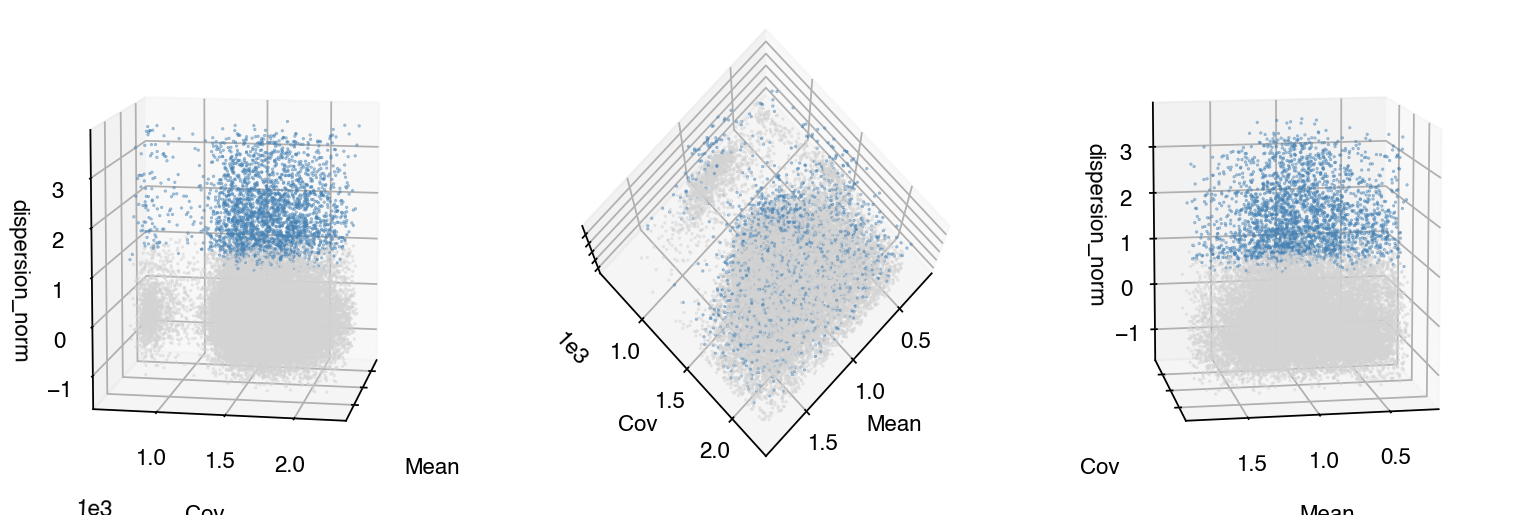

In [17]:
selection = ch_hvf_df['gene_subset']
print(f'Total Feature Number:     {selection.size}')
print(
    f'Highly Variable Feature:  {selection.sum()} ({(selection.sum() / selection.size * 100):.1f}%)'
)

fig, axes = plot_dispersion(ch_hvf_df,
                            hue='gene_subset',
                            zlab='dispersion_norm',
                            data_quantile=(0.01, 0.99),
                            save_animate_path=None,
                            fig_kws=None)
fig.savefig(fig_dir / f'ch_highly_variable_feature.{clustering_feature}.png',
            bbox_inches='tight')

### mCG HVF

In [18]:
cg_hvf_df = mcds.highly_variable_methylation_feature(
    var_dim=clustering_feature,
    mc_type='CGN',
    min_disp=None,
    max_disp=None,
    min_mean=min_cg_hvf_mean,
    max_mean=max_cg_hvf_mean,
    n_top_feature=cg_hvf_top,
    bin_min_features=5,
    mean_binsize=0.01,
    cov_binsize=10)

Total Feature Number:     25198
Highly Variable Feature:  2999 (11.9%)


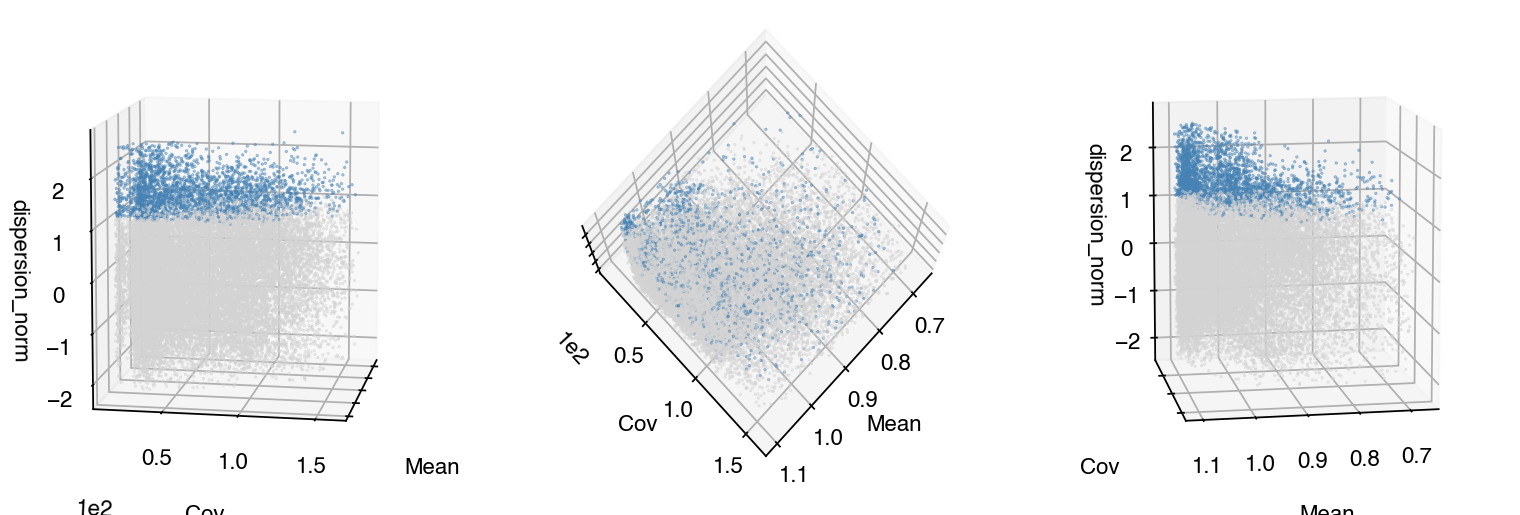

In [19]:
selection = cg_hvf_df['gene_subset']
print(f'Total Feature Number:     {selection.size}')
print(
    f'Highly Variable Feature:  {selection.sum()} ({(selection.sum() / selection.size * 100):.1f}%)'
)

fig, axes = plot_dispersion(cg_hvf_df,
                            hue='gene_subset',
                            zlab='dispersion_norm',
                            data_quantile=(0.01, 0.99),
                            save_animate_path=None,
                            fig_kws=None)
fig.savefig(fig_dir / f'cg_highly_variable_feature.{clustering_feature}.png',
            bbox_inches='tight')

## Get Anndata

### Load HVF

In [20]:
selected_ch_feature = ch_hvf_df[ch_hvf_df['gene_subset']].index
selected_cg_feature = cg_hvf_df[cg_hvf_df['gene_subset']].index

mcds = mcds.sel(chrom100k=(selected_ch_feature | selected_cg_feature))
mcds['chrom100k_da_rate'].load()

<xarray.DataArray 'chrom100k_da_rate' (cell: 460, chrom100k: 5682, mc_type: 2)>
array([[[0.877481, 0.375004],
        [1.120303, 1.270539],
        ...,
        [1.113855, 0.919922],
        [0.668326, 0.917259]],

       [[0.706338, 0.364926],
        [1.06882 , 1.365804],
        ...,
        [1.085202, 1.514226],
        [0.752366, 0.864915]],

       ...,

       [[0.158173, 0.458575],
        [1.069386, 1.16205 ],
        ...,
        [1.048134, 1.217258],
        [1.025048, 0.719045]],

       [[0.842262, 0.325525],
        [1.095518, 0.957187],
        ...,
        [1.045271, 1.110272],
        [1.025574, 1.236972]]])
Coordinates:
  * mc_type              (mc_type) object 'CGN' 'CHN'
    strand_type          <U4 'both'
  * cell                 (cell) object '2C_M_107' '2C_M_1083' ... '5D_M_978'
  * chrom100k            (chrom100k) int64 36 45 46 48 ... 26335 26336 26338
    chrom100k_chrom      (chrom100k) object 'chr1' 'chr1' ... 'chrX' 'chrX'
    chrom100k_bin_start  (chrom100

### CH adata

In [21]:
ch_adata = mcds.sel(chrom100k=selected_ch_feature).to_ann(
    f'{clustering_feature}_da_rate', var_dim=clustering_feature, mc_type='CHN')
ch_adata.write_h5ad(result_dir / 'mch_adata.norm_per_cell.hvf.h5ad')

Transforming to str index.


In [22]:
ch_adata

AnnData object with n_obs × n_vars = 460 × 3000 

### CG adata

In [23]:
cg_adata = mcds.sel(chrom100k=selected_cg_feature).to_ann(
    f'{clustering_feature}_da_rate', var_dim=clustering_feature, mc_type='CGN')
cg_adata.write_h5ad(result_dir / 'mcg_adata.norm_per_cell.hvf.h5ad')

Transforming to str index.


In [24]:
cg_adata

AnnData object with n_obs × n_vars = 460 × 2999 

## Prepare Gene

In [25]:
if clustering_feature != 'gene':
    mcds.add_gene_rate(in_memory=False,
                       output_prefix=str(result_dir / 'SelectedCell'),
                       cell_chunks=10000)